# 0.README

### 모델구조

병원의 상담원과 고객의 통화내용을 네 문장으로 나누어 통해 상담원을 3가지로 평가(적극성, 전달능력, 경청)이진분류하는 시스템입니다.


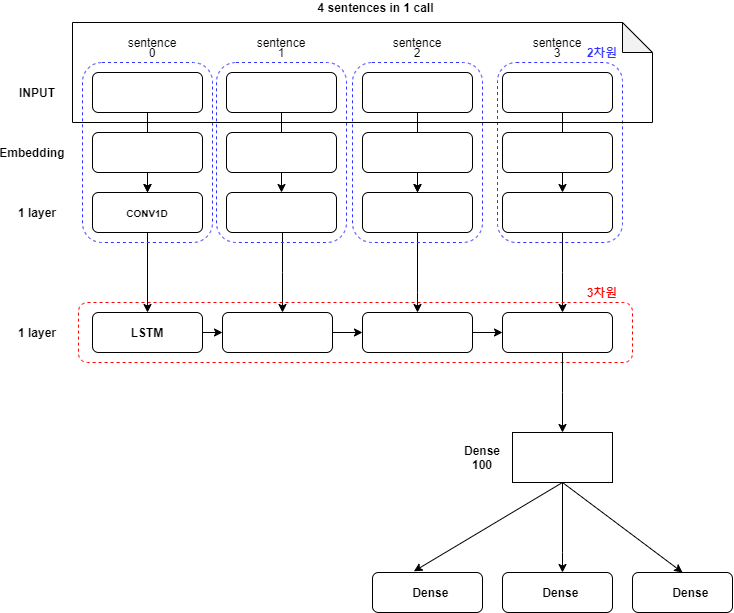

### 환경
* Python 3.6 
* GPU: Nvidia K80, T4, P4, P100
* tensorflow 2.3.0



# 1.데이터 전처리

In [1]:
import os
import pandas as pd
import openpyxl
import warnings
warnings.filterwarnings('ignore')

### 데이터구조

* 원천데이터의 분류시 적합(1)/부적합(0)의 불균형하여 가상데이터를 직접 만들었습니다

```bash
broadcns_project/
├── data/
│   ├── raw_data.xlsx
│   └── raw_sample.xlsx
├── pikle/
│   ├── df_labels.pickle
│   ├── df_virtualdata.pickle
│   ├── labels.pickle
│   └── preprocessed_data.pickle
└── callcenter_evaluation_classification/
     └── callcenter_evaluation_classification.ipynb
```

#### 데이터
* raw_data.xlsx: 통화내용, 평가 원천데이터
* raw_sample.xlsx: 통화내용 샘플

---
#### 피클파일
* preprocessed_data.pickle: 네 문장에서 키워드 추출한 데이터플레임 피클파일(원천)
* df_labels.pickle: 평가 라벨링한 종속변수 데이터프레임 피클파일(원천)
* df_virtualdata.pickle:네 문장에서 키워드 추출한 데이터플레임 피클파일(가상)
* labels.pickle: 평가 라벨링한 종속변수 데이터프레임 피클파일(가상)

---
#### 노트북파일
* callcenter_evaluation_classification.ipynb: 통화내용 평가분류과정 최종 노트북파일

### 원천 데이터 샘플

In [ ]:
# Raw Data Folder
path = 'raw_sample.xlsx'
raw_sample = pd.read_excel(path)


# Data we made Folder  
path2 = 'new_excel'

In [ ]:
raw_sample.head()

,1,정성을 다하겠습니다. 진료 예약 센터 [이름]입니다.
0,2,진료 예약하려고 하는데요.
1,1,고객님 어디가 불편하십니까?
2,2,발바닥이랑 손가락 마디마디라고 해야 되나?
3,1,"손가락 마디, 통증이 있으신 거예요?"


### 원천 데이터 -> 4개 연속된 문장 변환 함수
문장간의 관계를 고려한 라벨링을 위해 붙여준다.

In [ ]:
# 원천 데이터 4개 문장으로 이어붙이기
def open_and_make(path):
    folder = os.listdir(path)
    for i in folder:
        df = pd.read_excel(path+'\\'+i)
    
        new_df = make_new_arrange(df)
        
        new_df.to_excel(f'{path}\\new_{i}')
        
    return new_excel

def make_new_arrange(df):
    df_1 = df.iloc[:-3,1].reset_index()
    df_1.drop(['index'],axis=1,inplace=True)
    df_2 = df.iloc[1:-2,1].reset_index()
    df_2.drop(['index'],axis=1,inplace=True)
    df_3 = df.iloc[2:-1,1].reset_index()
    df_3.drop(['index'],axis=1,inplace=True)
    df_4 = df.iloc[3:,1].reset_index()
    df_4.drop(['index'],axis=1,inplace=True)
    new_df = pd.concat([df_1,df_2,df_3,df_4],axis=1,ignore_index=True)
    
    return new_df

### 라벨링된 데이터

In [2]:
path = 'raw_data.xlsx'
df = pd.read_excel(path)

print(len(df))
df.head()

9149


,index,Sentence1,Sentence2,Sentence3,Sentence4,적극성,전달능력,경청
0,0,건강하세요. 예약 센터 [이름]입니다.,생년월일이 [생년월일]입니다.,[생년월일]이요? 성함이 어떻게 되세요?,[이름].,1,1,1
1,1,생년월일이 [생년월일]입니다.,[생년월일]이요? 성함이 어떻게 되세요?,[이름].,"예, 잠시만요. 확인되셨고 전화번호 [전화번호] 그대로 사용하시나요?",1,1,1
2,2,[생년월일]이요? 성함이 어떻게 되세요?,[이름].,"예, 잠시만요. 확인되셨고 전화번호 [전화번호] 그대로 사용하시나요?",네.,1,1,1
3,3,[이름].,"예, 잠시만요. 확인되셨고 전화번호 [전화번호] 그대로 사용하시나요?",네.,어떤 점 도와드릴까요?,1,1,1
4,4,"예, 잠시만요. 확인되셨고 전화번호 [전화번호] 그대로 사용하시나요?",네.,어떤 점 도와드릴까요?,지금 비뇨기과가 지금 9월 2일로 돼 있잖아요? [이름] 교수님? 그 9월 23일로...,1,1,1


### Khaiii 분석기를 이용한 키워드 추출
주로 중요하다 생각된 키워드(일반명사 NNG ex. 예약, 전화 / 일반동사 VV ex. 하다, 보다 / 기타 ex. ~요 (끝맺음 말)

In [ ]:
# Khaiii설치
!git clone https://github.com/kakao/khaiii.git
!pip install cmake
!mkdir build
!cd build && cmake /content/khaiii
!cd /content/build/ && make all
!cd /content/build/ && make resource
!cd /content/build && make install
!cd /content/build && make package_python
!pip install /content/build/package_python

In [ ]:
# 키워드 추출 코드
from khaiii import KhaiiiApi
api = KhaiiiApi()
key_content = content[:]
for i in range(4):
    for j in range(len(content)):
        key_word = []
        for word in api.analyze(content.iloc[j,i]):
            for morph in word.morphs:
                 if morph.tag == 'NNG' or morph.tag == 'VV' or morph.tag == 'EC' or morph.tag == 'EF' or  morph.tag == 'NNB' or morph.tag == 'EP' or morph.tag == 'MAG' or morph.lex == '?' or morph.tag == 'SN' or morph.tag == 'JX'  or morph.tag == 'JKB'  or morph.tag == 'ETM' or morph.tag == 'VCP' or morph.tag == 'VA' or morph.tag == 'IC' or morph.tag == 'JKS' or morph.tag == 'VX' or morph.tag == 'NP' or morph.tag == 'XSV' or morph.tag == 'XSN' or morph.tag == 'MM' or morph.tag == 'JKO' or morph.tag == 'MAJ' or morph.tag == 'NNP' :
                    key_word.append(morph.lex)
    key_content.iloc[j,i] = key_word

### 피클파일 출력
(Khaiii 분석기를 이용해 추출한 키워드)

In [7]:
import gzip, pickle

# 키워드 추출된 문장
with gzip.open('preprocessed_data.pickle','rb') as f:
    key_content = pickle.load(f)

# 라벨 추출
with gzip.open('labels.pickle','rb') as f:
    labels = pickle.load(f)
    
# 문장 키워드 추출
with gzip.open('df_virtualdata.pickle','rb') as f:
    key_content_virtual = pickle.load(f)

# 라벨 추출
with gzip.open('df_labels.pickle','rb') as f:
    labels_virtual = pickle.load(f)

### 원천 데이터의 문장 / 라벨 출력

In [ ]:
print(key_content.shape)
key_content.head()

(9149, 4)


,Unnamed: 1,Unnamed: 1.1,Unnamed: 1.2,Unnamed: 1.3
0,"[건강, 어요, 예약, 센터, [, 이름, ], ㅂ니다]","[생년월일, [, 생년, 월, 일, ], ㅂ니다]","[[, 생년, 월, 일, ], 요, ?, 성, 함, 어떻, 되, 어요, ?]","[[, 이름, ]]"
1,"[생년월일, [, 생년, 월, 일, ], ㅂ니다]","[[, 생년, 월, 일, ], 요, ?, 성, 함, 어떻, 되, 어요, ?]","[[, 이름, ]]","[예, 잠시, 만요, 확인, 전화번호, [, 전화번호, ], 그대로, 사용, 나요, ?]"
2,"[[, 생년, 월, 일, ], 요, ?, 성, 함, 어떻, 되, 어요, ?]","[[, 이름, ]]","[예, 잠시, 만요, 확인, 전화번호, [, 전화번호, ], 그대로, 사용, 나요, ?]",[네]
3,"[[, 이름, ]]","[예, 잠시, 만요, 확인, 전화번호, [, 전화번호, ], 그대로, 사용, 나요, ?]",[네],"[어떤, 점, 돕, ㄹ까요, ?]"
4,"[예, 잠시, 만요, 확인, 전화번호, [, 전화번호, ], 그대로, 사용, 나요, ?]",[네],"[어떤, 점, 돕, ㄹ까요, ?]","[지금, 비뇨기과, 지금, 9, 월, 2, 일, 되, 잖아요, ?, [, 이름, ]..."


In [ ]:
print(labels.shape)
labels.head()

(9149, 3)


,적극성,전달능력,경청
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


### 직접 생성한 데이터 문장 / 라벨 출력

In [ ]:
print(key_content_virtual.shape)
key_content_virtual.head()

(663, 4)


,s1,s2,s3,s4
0,"[너, 저, 배, 가, 아프, 아서요]","[배, 요, ?]",[네],"[배, 가, 어떻, 게, 아프, 시, 어요, ?]"
1,"[배, 요, ?]",[네],"[배, 가, 어떻, 게, 아프, 시, 어요, ?]","[모르, 겠, 어요, 그냥, 막, 아프, 아요, 찌르, 는, 것, 처럼]"
2,[네],"[배, 가, 어떻, 게, 아프, 시, 어요, ?]","[모르, 겠, 어요, 그냥, 막, 아프, 아요, 찌르, 는, 것, 처럼]","[찌르, 는, 것, 처럼, 요, ?]"
3,"[배, 가, 어떻, 게, 아프, 시, 어요, ?]","[모르, 겠, 어요, 그냥, 막, 아프, 아요, 찌르, 는, 것, 처럼]","[찌르, 는, 것, 처럼, 요, ?]",[네]
4,"[모르, 겠, 어요, 그냥, 막, 아프, 아요, 찌르, 는, 것, 처럼]","[찌르, 는, 것, 처럼, 요, ?]",[네],"[어떻, 게, 하, 여, 드리, ㄹ까요, ?]"


In [ ]:
print(labels_virtual.shape)
labels_virtual.head()

(663, 3)


,적극성,전달능력,경청
0,1,1,0
1,1,1,0
2,1,1,0
3,1,1,0
4,1,1,0


In [ ]:
# 한번에 전처리 / 학습을 위해 두 데이터를 결합시켰다.

# 문장 결합
key_content.columns = ['s1','s2','s3','s4']
key_content = pd.concat([key_content_virtual,key_content], axis=0, ignore_index=True)

# 라벨 결합
labels = pd.concat([labels_virtual,labels],axis=0,ignore_index=True)

# 학습을 위한 라벨의 배열 변환
labels_ar = np.array(labels)

### 각 평가항목별 적합(1)부적합(0) 데이터

In [ ]:
new_data = pd.concat([key_content,labels], axis=1, ignore_index = True)
# 적극성
df_bad_a = new_data[new_data.iloc[:,4] ==0]

# 전달능력
df_bad_c = new_data[new_data.iloc[:,5] ==0]

# 경청
df_bad_l = new_data[new_data.iloc[:,6] ==0]

# 좋은 문장
df_good = new_data[(new_data.iloc[:,4] ==1) & (new_data.iloc[:,5] ==1) & (new_data.iloc[:,6] ==1)]

print(len(df_bad_a))
print(len(df_bad_c))
print(len(df_bad_l))
print(len(df_good))
print(len(key_content))

371
925
414
8262
9812


### 토큰화 전처리

In [ ]:
# Tokenizer를 위한 문장 String화
for i in range(4):
    for j in range(len(key_content)):
        key_content.iloc[j,i] = ' '.join(key_content.iloc[j,i])

key_content.head()

,s1,s2,s3,s4
0,너 저 배 가 아 프 아 서 요,배 요 ?,네,배 가 어 떻 게 아 프 시 어 요 ?
1,배 요 ?,네,배 가 어 떻 게 아 프 시 어 요 ?,모 르 겠 어 요 그 냥 막 아 프 아 요 찌 르 는 ...
2,네,배 가 어 떻 게 아 프 시 어 요 ?,모 르 겠 어 요 그 냥 막 아 프 아 요 찌 르 는 ...,찌 르 는 것 처 럼 요 ?
3,배 가 어 떻 게 아 프 시 어 요 ?,모 르 겠 어 요 그 냥 막 아 프 아 요 찌 르 는 ...,찌 르 는 것 처 럼 요 ?,네
4,모 르 겠 어 요 그 냥 막 아 프 아 요 찌 르 는 ...,찌 르 는 것 처 럼 요 ?,네,어 떻 게 하 여 드 리 ㄹ 까 요 ?


### Tokenizer(토큰화)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
# tokenizer Preprocessing
new_content = pd.concat([key_content.iloc[:,0],key_content.iloc[:,1],key_content.iloc[:,2],key_content.iloc[:,3]],axis=0,ignore_index=True)

In [ ]:
# 토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_content)

# 패딩
encoded = tokenizer.texts_to_sequences(new_content)
padded = pad_sequences(encoded)

### 토큰화된 데이터 출력

In [ ]:
print(padded)
print(padded.shape)

[[  0   0   0 ...  16  57   1]
 [  0   0   0 ...   0 299   1]
 [  0   0   0 ...   0   0  15]
 ...
 [  0   0   0 ...   6  12   1]
 [  0   0   0 ...   0   0  15]
 [  0   0   0 ...   6  49   1]]
(39248, 168)


### 문장 재 정렬

In [ ]:
sent_1 = padded[:int(len(padded)/4)]
sent_2 = padded[int(len(padded)/4):int(len(padded)/4*2)]
sent_3 = padded[int(len(padded)/4*2):int(len(padded)/4*3)]
sent_4 = padded[int(len(padded)/4*3):]

In [ ]:
len(sent_1)

9812

### Train / Test set 분리

In [ ]:
#train set
split = int(len(sent_1)*0.8)
x_train1 = sent_1[:split]
x_train2 = sent_2[:split]
x_train3 = sent_3[:split]
x_train4 = sent_4[:split]

#test set
x_test1 = sent_1[split:]
x_test2 = sent_2[split:]
x_test3 = sent_3[split:]
x_test4 = sent_4[split:]

# y train / test set 분리
y_train1 = labels_ar[:split,0]
y_train2 = labels_ar[:split,1]
y_train3 = labels_ar[:split,2]

y_test1 = labels_ar[split:,0]
y_test2 = labels_ar[split:,1]
y_test3 = labels_ar[split:,2]

In [ ]:
print(x_train1.shape)
print(x_test1.shape)
print(y_train1.shape)
print(y_test1.shape)

(7849, 168)
(1963, 168)
(7849,)
(1963,)


### 차원 출력

In [ ]:
# 가장 긴 문장 기준으로 padding 되어 있다.
print(x_train1.shape)
max_len = x_train1.shape[1]

(7849, 168)


# 2.Modeling




모델링은 
1. CNN + LSTM 
2.   CNN + LSTM (문장 단위로 입력)
3.   Conv1d 

세 가지 모델을사용하였으며 가장 성능이 좋은 CNN + LSTM 모델 코드만 넣었습니다

### 모델링 library 호출

In [ ]:
import sys
import os
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPool1D, MaxPooling1D, Reshape
from tensorflow.keras.models import Model
from keras.layers import Embedding, Flatten, LSTM, Dropout
from keras.optimizers import RMSprop

### CNN + LSTM Model

In [ ]:
# 2. CNN + LSTM (문장 단위로 입력)

inputs1 = Input(shape= (max_len, ))
x1 = Embedding(10000, 100, input_length=max_len)(inputs1)
conv1d_1 = Conv1D(filters=7, kernel_size=3, padding='valid', activation='relu')(x1)
d1 = Dropout(0.2)(conv1d_1)
pool1_1 = keras.layers.MaxPooling1D(pool_size=2, padding='same')(d1)
Flat1 = tf.keras.layers.Flatten()(pool1_1)

inputs2 = Input(shape=(max_len, ))
x2 = Embedding(10000, 100, input_length=max_len)(inputs2)
conv1d_2 = Conv1D(filters=7, kernel_size=3, padding='valid', activation='relu')(x2)
d2 = Dropout(0.2)(conv1d_2)
pool1_2 = keras.layers.MaxPooling1D(pool_size=2, padding='same')(d2)
Flat2 = tf.keras.layers.Flatten()(pool1_2)

inputs3 = Input(shape=(max_len, ))
x3 = Embedding(10000, 100, input_length=max_len)(inputs3)
conv1d_3 = Conv1D(filters=7, kernel_size=3, padding='valid', activation='relu')(x3)
d3 = Dropout(0.2)(conv1d_3)
pool1_3 = keras.layers.MaxPooling1D(pool_size=2, padding='same')(d3)
Flat3 = tf.keras.layers.Flatten()(pool1_3)

inputs4 = Input(shape=(max_len, ))
x4 = Embedding(10000, 100, input_length=max_len)(inputs4)
conv1d_4 = Conv1D(filters=7, kernel_size=3, padding='valid', activation='relu')(x4)
d4 = Dropout(0.2)(conv1d_4)
pool1_4 = keras.layers.MaxPooling1D(pool_size=2, padding='same')(d4)
Flat4 = tf.keras.layers.Flatten()(pool1_4)

concat = tf.keras.layers.Concatenate(axis=1)([Flat1, Flat2, Flat3, Flat4])

concat_reshape = tf.keras.layers.Reshape((4,int(concat.shape[1]/4),), input_shape=(concat.shape[1],))(concat)

lstm_layer = LSTM(64, input_shape = (4,294))(concat_reshape)

x = Dropout(0.3)(lstm_layer)

dense = Dense(100, activation='relu')(x)

d_1 = Dropout(0.3)(dense)

activation_output = Dense(1, activation='sigmoid',name='activation_output')(d_1)
communication_output = Dense(1, activation='sigmoid',name='communication_output')(d_1)
listening_output = Dense(1, activation='sigmoid',name='listening_output')(d_1)

model = Model([inputs1,inputs2,inputs3,inputs4], [activation_output,communication_output,listening_output])

In [ ]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 168)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 168)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 168)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 168)]        0                                            
_______________________________________________________________________________________

In [ ]:
# 모델 컴파일
model.compile(optimizer = 'rmsprop', loss = ['binary_crossentropy','binary_crossentropy','binary_crossentropy'], metrics=['accuracy',tf.keras.metrics.AUC()])

### Callback function 호출

In [ ]:
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import Callback

import time

#### loss 출력

In [ ]:
from IPython.display import clear_output

class PlotLosses(Callback):

    def on_train_begin(self, logs={}):

        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []

        self.fig = plt.figure()

        self.logs = []


    def on_epoch_end(self, epoch, logs={}):

        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        print("loss = ", self.losses[-1], ", val_loss = ", self.val_losses[-1])


In [ ]:
plot_losses = PlotLosses()

### 학습

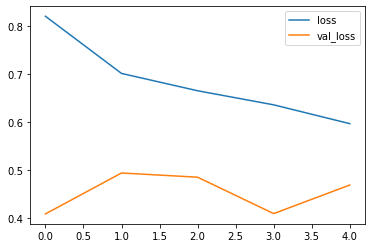

loss =  0.5970418453216553 , val_loss =  0.46895864605903625
210/210 [==============================] - 8s 36ms/step - loss: 0.5970 - activation_output_loss: 0.1292 - communication_output_loss: 0.3189 - listening_output_loss: 0.1489 - activation_output_accuracy: 0.9530 - activation_output_auc_1: 0.9026 - communication_output_accuracy: 0.8742 - communication_output_auc_1: 0.7856 - listening_output_accuracy: 0.9465 - listening_output_auc_1: 0.8848 - val_loss: 0.4690 - val_activation_output_loss: 0.1228 - val_communication_output_loss: 0.1956 - val_listening_output_loss: 0.1506 - val_activation_output_accuracy: 0.9803 - val_activation_output_auc_1: 0.6476 - val_communication_output_accuracy: 0.9599 - val_communication_output_auc_1: 0.5653 - val_listening_output_accuracy: 0.9764 - val_listening_output_auc_1: 0.5818


In [ ]:
# 학습
history = model.fit([x_train1,x_train2,x_train3,x_train4], 
                    [y_train1, y_train2, y_train3],
                    batch_size=30,
                    epochs= 5,
                    validation_split=0.2,
                    callbacks=[plot_losses])

In [ ]:
x_test = [x_test1, x_test2, x_test3, x_test4]
y_test = [y_test1,y_test2,y_test3]

# 3.Result

### Test data 예측

In [ ]:
# 결과값 확인
y_hat = model.predict(x_test)

# 속성별 분류
activation = pd.DataFrame(y_hat[0])
communication = pd.DataFrame(y_hat[1])
listening = pd.DataFrame(y_hat[2])

# DataFrame화
outputs = pd.concat([activation, communication, listening],axis = 1)
outputs.columns = ["pre_적극성", "pre_의사소통", "pre_경청"]
outputs

,pre_적극성,pre_의사소통,pre_경청
0,0.998208,0.935753,0.996220
1,0.998604,0.949893,0.997055
2,0.996699,0.929283,0.992893
3,0.994384,0.920846,0.990074
4,0.997495,0.927788,0.996815
...,...,...,...
1958,1.000000,0.998465,1.000000
1959,1.000000,0.994541,1.000000
1960,0.999986,0.997698,0.999956
1961,0.999871,0.991900,0.999601


### 문장단위 결과 확인

In [ ]:
test_df = df[-len(x_test1):].reset_index()
test_df = test_df.drop(['index','level_0'],axis=1)

In [ ]:
real_output = pd.concat([test_df,outputs],axis=1, ignore_index=True)
real_output.columns = ['s1','s2','s3','s4','적극성','의사소통','경청','pre_적극성','pre_의사소통','pre_경청']

### Accuracy

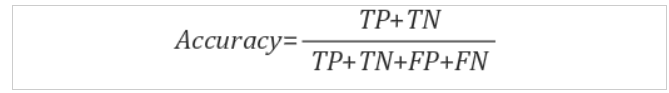

In [ ]:
from sklearn.metrics import accuracy_score

print('적극성 정확도 : ', accuracy_score(round(outputs['pre_적극성']), y_test[0]))
print('의사소통 정확도 : ', accuracy_score(round(outputs['pre_의사소통']), y_test[1]))
print('경청 정확도 : ', accuracy_score(round(outputs['pre_경청']), y_test[2]))

적극성 정확도 :  0.978604177279674
의사소통 정확도 :  0.9612837493632196
경청 정확도 :  0.9816607233825777


### AUC

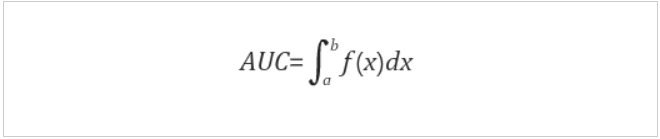

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score

In [ ]:
y_hat0 = np.array(outputs['pre_적극성'])
y_hat1 = np.array(outputs['pre_의사소통'])
y_hat2 = np.array(outputs['pre_경청'])

In [ ]:
print('적극성 Auc : ', roc_auc_score(y_test1,y_hat0))
print('의사소통 Auc : ', roc_auc_score(y_test2,y_hat1))
print('경청 Auc : ', roc_auc_score(y_test3,y_hat2))

적극성 Auc :  0.5020016856300042
의사소통 Auc :  0.6406019022118093
경청 Auc :  0.6535417747794499


### 예측점수 조정



*   예측점수는 예측확률을 점수화 한것 입니다.
*   예측점수의 분포조정을 위해 min-max 정규화를 사용하였습니다.



In [ ]:
print('적극성 최대 : ',outputs['pre_적극성'].max())
print('적극성 최소 : ',outputs['pre_적극성'].min())
a_max = outputs['pre_적극성'].max()
a_min = outputs['pre_적극성'].min()

적극성 최대 :  1.0
적극성 최소 :  0.57851857


In [ ]:
print('의사소통 최대 : ',outputs['pre_의사소통'].max())
print('의사소통 최소 : ',outputs['pre_의사소통'].min())
c_max = outputs['pre_의사소통'].max()
c_min = outputs['pre_의사소통'].min()

의사소통 최대 :  0.9999387
의사소통 최소 :  0.50786465


In [ ]:
print('경청 최대 : ',outputs['pre_경청'].max())
print('경청 최소 : ',outputs['pre_경청'].min())
l_max = outputs['pre_경청'].max()
l_min = outputs['pre_경청'].min()

경청 최대 :  1.0
경청 최소 :  0.55194324


In [ ]:
for i in range(len(outputs)):
    real_output['pre_적극성'][i] = ((real_output['pre_적극성'][i] - a_min) / (a_max - a_min))*100
    real_output['pre_의사소통'][i] = ((real_output['pre_의사소통'][i] - c_min) / (c_max - c_min))*100
    real_output['pre_경청'][i] = ((real_output['pre_경청'][i] - l_min) / (l_max - l_min))*100
real_output.iloc[:,4:7] = real_output.iloc[:,4:7]*100
real_output.iloc[368:370,:]

,s1,s2,s3,s4,적극성,의사소통,경청,pre_적극성,pre_의사소통,pre_경청
368,4학년 올라가요? 그러면 아이 3년 동안 성장 수치가 기재가 되어 있는 신체 검사 ...,NEIS(나이스)요?,"네, NEIS(나이스)라는 어플이나 홈페이지에서 학교 기록이 다 거기에 기재가 된다...","네, [이름] 키요?",100,0,100,98.974075,37.201374,98.398682
369,NEIS(나이스)요?,"네, NEIS(나이스)라는 어플이나 홈페이지에서 학교 기록이 다 거기에 기재가 된다...","네, [이름] 키요?",양가 조부모님 키 확인해서 오셔야 되고 그리고 오실 때 등본을 한 부 가지고 오시는...,100,0,100,99.871620,56.893654,99.821869


### 1개의 통화 Sample 추출

In [ ]:
sample_data = real_output.iloc[340:378,:]

In [ ]:
sample_data.iloc[25:35,:]

,s1,s2,s3,s4,적극성,의사소통,경청,pre_적극성,pre_의사소통,pre_경청
365,네.,그리고 아이 혹시 3학년이에요?,"이제 4학년, 네, 3학년.",4학년 올라가요? 그러면 아이 3년 동안 성장 수치가 기재가 되어 있는 신체 검사 ...,100,100,100,99.997765,96.578651,99.994759
366,그리고 아이 혹시 3학년이에요?,"이제 4학년, 네, 3학년.",4학년 올라가요? 그러면 아이 3년 동안 성장 수치가 기재가 되어 있는 신체 검사 ...,NEIS(나이스)요?,100,100,100,99.975418,89.228691,99.926888
367,"이제 4학년, 네, 3학년.",4학년 올라가요? 그러면 아이 3년 동안 성장 수치가 기재가 되어 있는 신체 검사 ...,NEIS(나이스)요?,"네, NEIS(나이스)라는 어플이나 홈페이지에서 학교 기록이 다 거기에 기재가 된다...",100,0,100,99.998375,96.265915,99.995659
368,4학년 올라가요? 그러면 아이 3년 동안 성장 수치가 기재가 되어 있는 신체 검사 ...,NEIS(나이스)요?,"네, NEIS(나이스)라는 어플이나 홈페이지에서 학교 기록이 다 거기에 기재가 된다...","네, [이름] 키요?",100,0,100,98.974075,37.201374,98.398682
369,NEIS(나이스)요?,"네, NEIS(나이스)라는 어플이나 홈페이지에서 학교 기록이 다 거기에 기재가 된다...","네, [이름] 키요?",양가 조부모님 키 확인해서 오셔야 되고 그리고 오실 때 등본을 한 부 가지고 오시는...,100,0,100,99.871620,56.893654,99.821869
370,"네, NEIS(나이스)라는 어플이나 홈페이지에서 학교 기록이 다 거기에 기재가 된다...","네, [이름] 키요?",양가 조부모님 키 확인해서 오셔야 되고 그리고 오실 때 등본을 한 부 가지고 오시는...,"아니요, 아니요, 등본까지 들었어요, 예, 등본이랑?",100,0,100,99.988800,90.821213,99.981537
371,"네, [이름] 키요?",양가 조부모님 키 확인해서 오셔야 되고 그리고 오실 때 등본을 한 부 가지고 오시는...,"아니요, 아니요, 등본까지 들었어요, 예, 등본이랑?",그리고 [이름] 신분증 같이 가지고 오시면 되시고요.,100,0,100,99.998299,99.287857,99.996094
372,양가 조부모님 키 확인해서 오셔야 되고 그리고 오실 때 등본을 한 부 가지고 오시는...,"아니요, 아니요, 등본까지 들었어요, 예, 등본이랑?",그리고 [이름] 신분증 같이 가지고 오시면 되시고요.,신분증이요? 예.,100,0,100,99.999832,99.847237,99.999504
373,"아니요, 아니요, 등본까지 들었어요, 예, 등본이랑?",그리고 [이름] 신분증 같이 가지고 오시면 되시고요.,신분증이요? 예.,최근 한 달 이내에 해외나 집단 발생 시설 다녀오신 적은 없으세요?,100,100,100,99.999771,99.827660,99.999229
374,그리고 [이름] 신분증 같이 가지고 오시면 되시고요.,신분증이요? 예.,최근 한 달 이내에 해외나 집단 발생 시설 다녀오신 적은 없으세요?,"네, 없어요.",100,100,100,99.984505,97.998352,99.958252


### 통화 Sample 최종 평점 출력

In [ ]:
active_score = sample_data['적극성'].sum()/len(sample_data)
communication_score = sample_data['의사소통'].sum()/len(sample_data)
listening_score = sample_data['경청'].sum()/len(sample_data)
pre_active_score = sample_data['pre_적극성'].sum()/len(sample_data)
pre_communication_score = sample_data['pre_의사소통'].sum()/len(sample_data)
pre_listening_score = sample_data['pre_경청'].sum()/len(sample_data)

# final_sample = pd.concat([sample_data['s1'],active_score,communication_score,listening_score,pre_active_score,pre_communication_score,pre_listening_score],axis=0)

In [ ]:
score = pd.DataFrame({'active_score':[active_score], 'communication_score' : [communication_score],
                     'listening_score' : [listening_score], 'pre_active_score':[pre_active_score],
                     'pre_communication_score':[pre_communication_score], 'pre_listening_score':[pre_listening_score] })

In [ ]:
final_sample = pd.concat([sample_data['s1'].reset_index(),score],axis=1,ignore_index=True)
final_sample.drop([0],axis=1,inplace=True)
final_sample.columns = ['sentences','active_score','communication_score','listening_score','pre_active_score','pre_communication_score','pre_listening_score']
final_sample.head()

,sentences,active_score,communication_score,listening_score,pre_active_score,pre_communication_score,pre_listening_score
0,오전 진료시고요. 10시 50분 자리가 가장 빠르세요.,100.0,84.210526,100.0,99.557489,91.977526,99.319355
1,10시 50분으로 [이름] 씨 예약 좀 해 주세요.,NaN,NaN,NaN,NaN,NaN,NaN
2,"그러시고, 이날은 진료가, 진료를 누가 오시나요? 환자분 본인도 오시나요?",NaN,NaN,NaN,NaN,NaN,NaN
3,저 혹시 아이 소아내분비과 예약을 좀 하고 싶은데요.,NaN,NaN,NaN,NaN,NaN,NaN
4,어떤 증상으로 내분비과 진료 원하시는 거세요?,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
final_sample.to_excel('Result.xlsx')